## Project Name: "Predicting Medical Insurance Costs: Regression Analysis"

### Project Goal

Predict medical expenses based on patient characteristics using regression analysis.

### Dataset Information:

Below is a brief description of each column:
* **age:** age (int)
* **sex:** gender (male or female)
* **bmi:** body mass index (float)
* **children:** number of children covered by the insurance (int)
* **smoker:** whether the person is a smoker (yes or no)
* **region:** region of residence (northeast, northwest, southeast, southwest)
* **charges:** medical expenses (float)

In [87]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

### Data Understanding and Exploration (EDA)

#### Data Overview

In [59]:
data = pd.read_csv('medical_insurance.csv')

In [60]:
# Check the shape of the dataset (number of rows and columns)
print('Dataset Shape:', data.shape)

Dataset Shape: (2772, 7)


In [61]:
# Check the basic info of the dataset, including data types and non-null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


In [62]:
# Check for missing values
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [63]:
# Get basic statistics for numerical columns
data.describe()

,age,bmi,children,charges
count,2772.000000,2772.000000,2772.000000,2772.000000
mean,39.109668,30.701349,1.101732,13261.369959
std,14.081459,6.129449,1.214806,12151.768945
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.220000,0.000000,4687.797000
50%,39.000000,30.447500,1.000000,9333.014350
75%,51.000000,34.770000,2.000000,16577.779500
max,64.000000,53.130000,5.000000,63770.428010


In [64]:
# Check the unique values for categorical columns
for col in ['sex', 'smoker', 'region']:
    print(f'{col}: {data[col].unique()}')

sex: ['female' 'male']
smoker: ['yes' 'no']
region: ['southwest' 'southeast' 'northwest' 'northeast']


#### Data Visualization

In [65]:
# Set plot style
sns.set(style='whitegrid')

#### *Visualizing the distribution of numerical variables*

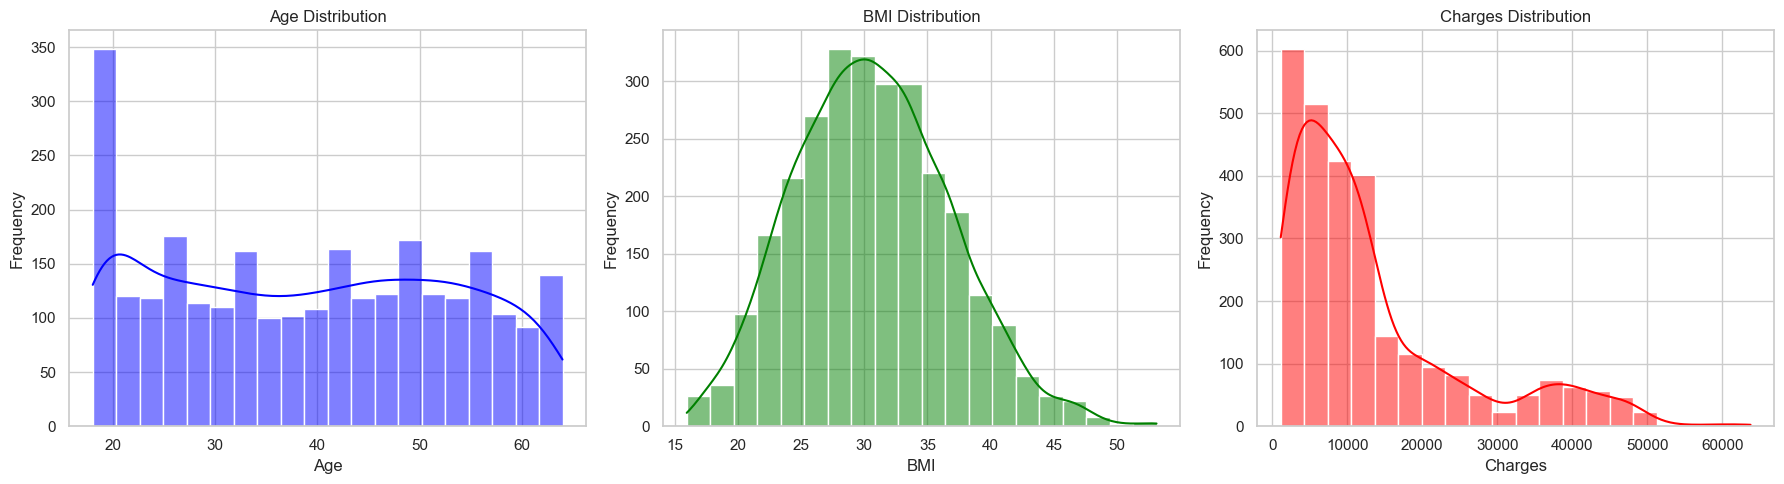

In [66]:
# Create subplots for histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram for age
sns.histplot(data['age'], kde=True, bins=20, color='blue', ax=axes[0])
axes[0].set_title('Age Distribution')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

# Histogram for bmi
sns.histplot(data['bmi'], kde=True, bins=20, color='green', ax=axes[1])
axes[1].set_title('BMI Distribution')
axes[1].set_xlabel('BMI')
axes[1].set_ylabel('Frequency')

# Histogram for charges
sns.histplot(data['charges'], kde=True, bins=20, color='red', ax=axes[2])
axes[2].set_title('Charges Distribution')
axes[2].set_xlabel('Charges')
axes[2].set_ylabel('Frequency')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

* **Age Distribution** appears to be fairly uniform across the range of ages, with no significant skewness. This indicates that the dataset has a good representation of various age groups, from young adults to older individuals.
* **BMI Distribution** is slightly right-skewed, meaning that the majority of individuals have lower BMI values, while a smaller number of individuals have higher BMIs.
* **Charges Distribution** is heavily right-skewed, indicating that while the most people have relatively low medical expenses, a smaller group experiences very high costs.

#### *Exploring Relationships Between Categorical Variables and Charges*

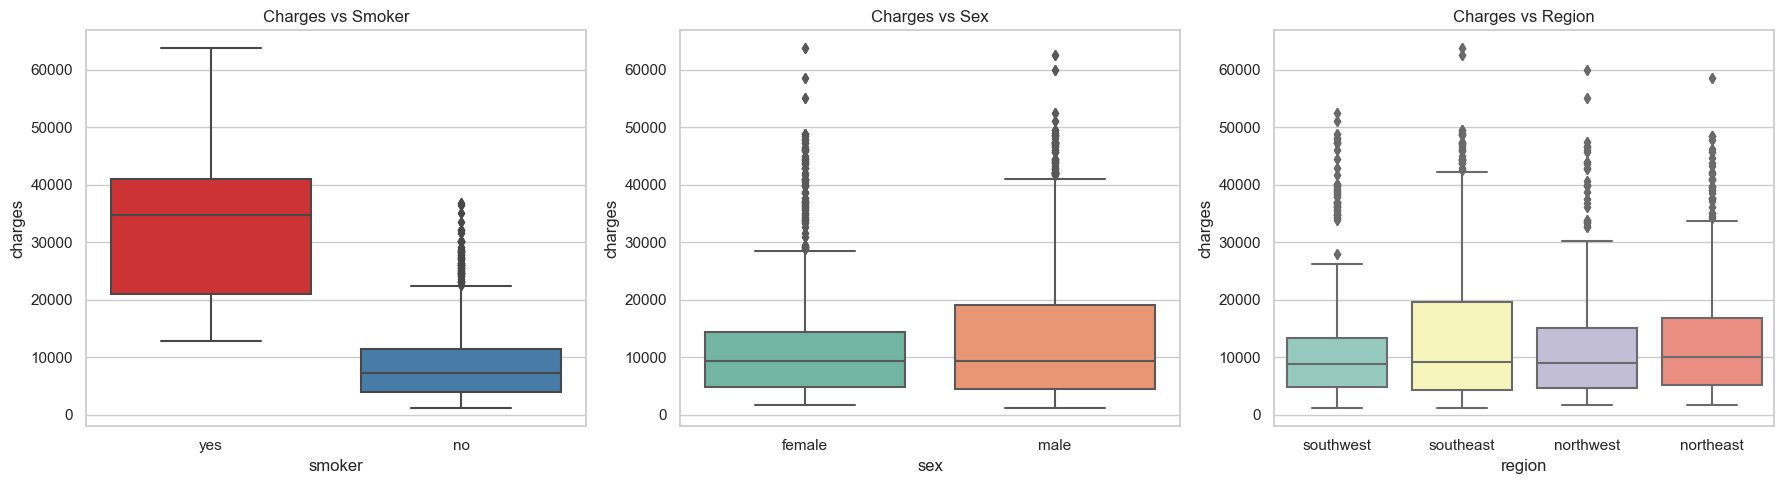

In [75]:
# Create subplots for boxplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Boxplot for charges vs smoker
sns.boxplot(x='smoker', y='charges', data=data, palette='Set1', ax=axes[0])
axes[0].set_title('Charges vs Smoker')

# Boxplot for charges vs sex
sns.boxplot(x='sex', y='charges', data=data, palette='Set2', ax=axes[1])
axes[1].set_title('Charges vs Sex')

# Boxplot for charges vs sex
sns.boxplot(x='region', y='charges', data=data, palette='Set3', ax=axes[2])
axes[2].set_title('Charges vs Region')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

**Charges vs Smoker:**
Smokers have a wider spread of dara and a significantly higher median expense. Smokers have no outliers, while non-smokers show more extreme cases. Smokers generally have consistently higher costs, but non-smokers have some cases with very high costs.

**Charges vs Sex:**
There is no significant difference in medical costs between males and females. Both genders have similar median medical expenses, though there might be slight variations in the spread and outliers. Gender is not a major determinant of medical expenses in this dataset.

**Charges vs Sex:**
Medical costs across regions are fairly similar. While there may be small variations in the median values and the spread of data, no one region stands out as having significantly higher or lower medical expenses. Region is not a strong predictor of medical costs.

#### *Correlation Analysis*

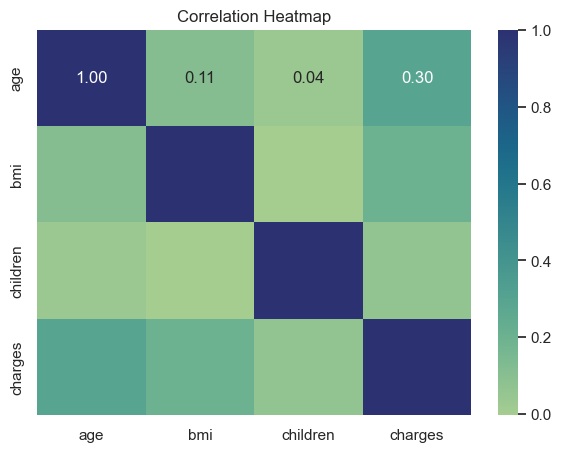

In [81]:
# Select only numerical columns for correlation analysis
numerical_data = data[['age', 'bmi', 'children', 'charges']]

# Calculate the correlation matrix
corr_matrix = numerical_data.corr()

# Create the heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='crest', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

* **Age** and **BMI** show moderate positive correlations with medical expenses, suggesting that these factors have some influence on costs.
* **Children** has almost no correlation with charges, meaning it’s not a significant factor in medical expenses based on this data.

### Data Preprocessing

#### *Feature Engineering*

In [82]:
# Encode categorical variables
data_encoded = pd.get_dummies(data, drop_first=True)

In [85]:
data_encoded.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


In [91]:
# Convert boolean columns to integers
data_encoded = data_encoded.astype(int)

In [92]:
data_encoded.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27,0,16884,0,1,0,0,1
1,18,33,1,1725,1,0,0,1,0
2,28,33,3,4449,1,0,0,1,0
3,33,22,0,21984,1,0,1,0,0
4,32,28,0,3866,1,0,1,0,0


#### *Check for Multicollinearity*

In [93]:
# Define the feature set (X) excluding the target variable 'charges'
X = data_encoded.drop(columns=['charges'])

# Add a constant column to account for the intercept
X_with_constant = sm.add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_with_constant.values, i+1) for i in range(X.shape[1])]

# Display the VIF data
print(vif_data)

            Feature       VIF
0               age  1.017917
1               bmi  1.115742
2          children  1.004017
3          sex_male  1.009897
4        smoker_yes  1.013507
5  region_northwest  1.530650
6  region_southeast  1.682433
7  region_southwest  1.550619


All VIF values are bellow, which indicates no multicollinearity isssues among the features.

#### *Standardizing the features*

In [94]:
# Define the feature set and the target variable
X = data_encoded.drop(columns=['charges'])
y = data_encoded['charges']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_scaled = scaler.fit_transform(X)

# Display the first few rows of the scaled features
pd.DataFrame(X_scaled, columns=X.columns).head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,-1.428353,-0.521945,-0.907084,-1.014536,1.978609,-0.561240,-0.617944,1.747178
1,-1.499381,0.453666,-0.083758,0.985673,-0.505406,-0.561240,1.618270,-0.572351
2,-0.789099,0.453666,1.562893,0.985673,-0.505406,-0.561240,1.618270,-0.572351
3,-0.433959,-1.334953,-0.907084,0.985673,-0.505406,1.781768,-0.617944,-0.572351
4,-0.504987,-0.359343,-0.907084,0.985673,-0.505406,1.781768,-0.617944,-0.572351


### Model Building and Evaluation

#### *Linear Regression*

In [95]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [96]:
# Initialize the linear regression model
model = LinearRegression()

In [97]:
# Train the model on the training data
model.fit(X_train, y_train)

LinearRegression()

In [98]:
# Predict on the test set
y_pred = model.predict(X_test)

In [100]:
# Evaluate the results
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 39953750.27870349
Root Mean Squared Error (RMSE): 6320.89790130354
R² Score: 0.7396828557409347


* RMSE of 6,320.90 indicates the average error between the predicted and actual medical charges.
* R² Score of 0.74 means that the model explains approximately 74% of the variance in the medical expenses. This is a relatively good result, indicating that the model performs reasonably well, but there is still room for improvement.

#### *Regularization with Ridge and Lasso Regression*

In [104]:
# Initialize Ridge and Lasso models
ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=1.0)

In [102]:
# Train Ridge regression model
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

In [105]:
# Train Lasso regression model
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)

In [109]:
# Evaluate Ridge model
ridge_mse = mean_squared_error(y_test, ridge_pred)
ridge_rmse = np.sqrt(ridge_mse)
ridge_r2 = r2_score(y_test, ridge_pred)

In [110]:
# Evaluate Lasso model
lasso_mse = mean_squared_error(y_test, lasso_pred)
lasso_rmse = np.sqrt(lasso_mse)
lasso_r2 = r2_score(y_test, lasso_pred)

In [111]:
# Display results
print(f"Ridge Regression - MSE: {ridge_mse}, RMSE: {ridge_rmse}, R²: {ridge_r2}")
print(f"Lasso Regression - MSE: {lasso_mse}, RMSE: {lasso_rmse}, R²: {lasso_r2}")

Ridge Regression - MSE: 39955869.32828624, RMSE: 6321.065521594143, R²: 0.7396690491537663
Lasso Regression - MSE: 39954446.74008477, RMSE: 6320.952993029197, R²: 0.7396783179732258


The performance of both Ridge and Lasso regression models is nearly identical to the basic linear regression model.
Regularization does not significantly improve the model's performance. This suggests that the model is not overfitting and that the features are already well-suited for prediction.

#### *Hyperparameter Tuning with GridSearchCV*

In [112]:
# Define the alpha values to search for both Ridge and Lasso
alpha_values = {'alpha': [0.01, 0.1, 1, 10, 100]}

In [113]:
# Ridge Regression with GridSearchCV
ridge_grid = GridSearchCV(Ridge(), alpha_values, scoring='neg_mean_squared_error', cv=5)
ridge_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [114]:
# Best alpha for Ridge
best_ridge_alpha = ridge_grid.best_params_['alpha']
ridge_best_model = ridge_grid.best_estimator_

In [115]:
# Eveluate Ridge model with best alpha
ridge_best_pred = ridge_best_model.predict(X_test)
ridge_best_mse = mean_squared_error(y_test, ridge_best_pred)
ridge_best_rmse = np.sqrt(ridge_best_mse)
ridge_best_r2 = r2_score(y_test, ridge_best_pred)

In [116]:
# Lasso Regression with GridSearchCV
lasso_grid = GridSearchCV(Lasso(), alpha_values, scoring='neg_mean_squared_error', cv=5)
lasso_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [117]:
# Best alpha for Lasso
best_lasso_alpha = lasso_grid.best_params_['alpha']
lasso_best_model = lasso_grid.best_estimator_

In [118]:
# Evaluate Lasso model with best alpha
lasso_best_pred = lasso_best_model.predict(X_test)
lasso_best_mse = mean_squared_error(y_test, lasso_best_pred)
lasso_best_rmse = np.sqrt(lasso_best_mse)
lasso_best_r2 = r2_score(y_test, lasso_best_pred)

In [119]:
# Display the results for both Ridge and Lasso
print(f"Ridge - Best Alpha: {best_ridge_alpha}, RMSE: {ridge_best_rmse}, R²: {ridge_best_r2}")
print(f"Lasso - Best Alpha: {best_lasso_alpha}, RMSE: {lasso_best_rmse}, R²: {lasso_best_r2}")

Ridge - Best Alpha: 1, RMSE: 6321.065521594143, R²: 0.7396690491537663
Lasso - Best Alpha: 10, RMSE: 6321.568434863137, R²: 0.7396276228792524


It appears that hyperparameter tuning for both Ridge and Lasso regression did not significantly improve the performance.

#### *Random Forest Regression*

In [121]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test set
rf_pred = rf_model.predict(X_test)

# Evaluate the model
rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_pred)

# Display the results
print(f"Random Forest - RMSE: {rf_rmse}, R²: {rf_r2}")

Random Forest - RMSE: 2753.8209418900415, R²: 0.9505897994065553


* **RMSE of 2,753.82:** This is much lower than the RMSE values from Ridge and Lasso (~6,321), indicating that the Random Forest model is making predictions with much smaller errors.
* **R² of 0.95:** This means that the Random Forest model explains 95% of the variance in the target variable (charges), a significant improvement over the 0.74 R² from Ridge and Lasso.

The Random Forest model outperforms linear models and regularization techniques in this case, making it a strong candidate for predicting medical expenses.

#### *Hyperparameter Tuning for Random Forest*

In [124]:
# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest with GridSearchCV
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the model to the training data
rf_grid.fit(X_train, y_train)

# Get the best model
best_rf_model = rf_grid.best_estimator_

# Evaluate the best model on the test set
rf_best_pred = best_rf_model.predict(X_test)
rf_best_mse = mean_squared_error(y_test, rf_best_pred)
rf_best_rmse = np.sqrt(rf_best_mse)
rf_best_r2 = r2_score(y_test, rf_best_pred)

# Display the results
print(f"Best Random Forest - RMSE: {rf_best_rmse}, R²: {rf_best_r2}")

Best Random Forest - RMSE: 2735.738253081015, R²: 0.9512365632027034


* RMSE of 2,735.74: This is slightly better than the previous untuned Random Forest model, which had an RMSE of 2,753.82. This means that hyperparameter tuning helped the model reduce prediction errors.
* R² of 0.9512: The model explains 95.12% of the variance in medical expenses, showing that Random Forest is performing very well.

#### *Feature Importance*

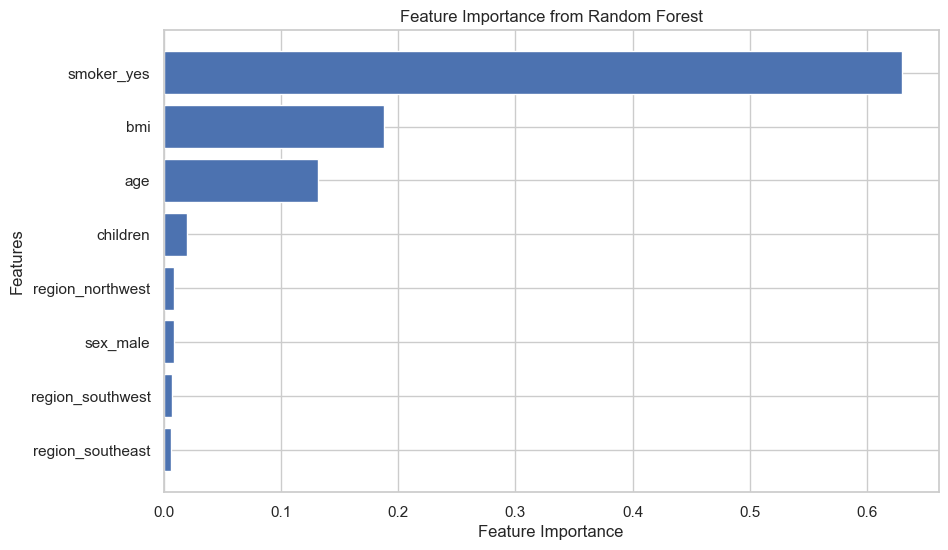

In [125]:
# Extract feature importance scores
feature_importances = best_rf_model.feature_importances_

# Convert to a DataFrame for easier interpretation
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()

**Smoker status, BMI, and age** are the key drivers of medical expenses, with smoking being the most influential factor.

### Residual Analysis

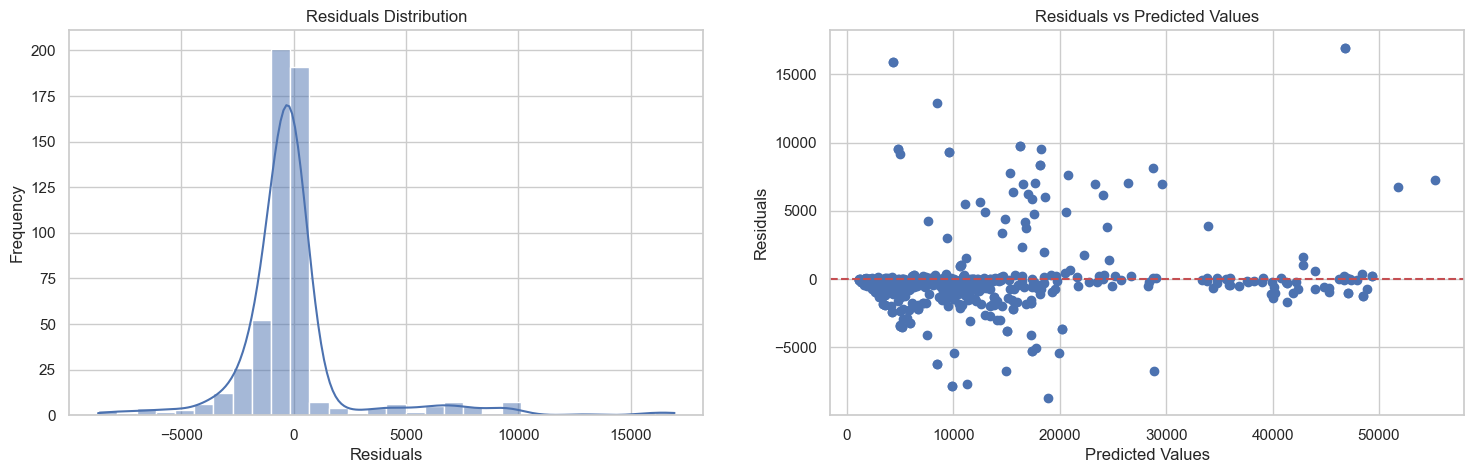

In [130]:
# Calculate residuals 
residuals = y_test - rf_best_pred

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Plot the residuals
sns.histplot(residuals, kde=True, bins=30, ax=axes[0])
axes[0].set_title('Residuals Distribution')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')

# Scatter plot of predicted vs residuals
axes[1].scatter(rf_best_pred, residuals)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_title('Residuals vs Predicted Values')
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')

plt.show()

* Histogram of residuals: We see a roughly normal distribution centered around zero. This suggests that the model is not systematically over- or under-predicting.
* Residuals vs. predicted values: The residuals are randomly scattered around zero, it means the model has captured most patterns in the data.

### Final Conclusions and Recomendations

#### *Summarizing Findings*

* The Random Forest model was the best-performing model with an R² of 0.9512 and an RMSE of 2,735.74 after hyperparameter tuning.
* The most important features driving medical insurance costs were:
1. Smoking status (63% importance)
2. BMI (18.8% importance)
3. Age (13.2% importance)

#### *Recommendations*

**1. Premium adjustment based on smoking status:**
 * Since smokers have much higher medical costs, insurers should consider higher premiums for smokers to cover potential medical expenses.

**2. Incentives for maintaining a healthy BMI:**
 * Insurers could provide discounts or incentives for individuals maintaining a healthy BMI to encourage healthier lifestyles and reduce future medical costs.

**3. Age-based premium adjustments:**
 * Since medical expenses rise with age, insurers could implement age-based premium adjustments to reflect the increasing risk of health issues as individuals get older.